In [1]:
CATEGORY = 'apple' # 'car', 'apple'

---

In [2]:
LABEL_PREFIX = 'sketch of a'

GRIDCELL_SIZE = 7
GRID_WIDTH = 32
GRID_HEIGHT = 32

RENDER_W_GRID = False

N_LABELS = 5
SEED = 5 # None

OVERWRITE = True

In [ ]:
MODEL = 'ViT-L/14'

# Imports

In [3]:
import os
from pathlib import Path

In [4]:
from itertools import product
from functools import reduce

In [5]:
import numpy as np

In [6]:
import torch

In [7]:
import clip

In [8]:
from PIL import Image, ImageDraw, ImageOps
import skimage

In [9]:
from tqdm import tqdm

In [10]:
import matplotlib.pyplot as plt

In [11]:
import pickle

In [12]:
import logging

In [13]:
import gc

---

In [14]:
from imagelib import Im

---

In [15]:
# Autoreload Custom Modules
%load_ext autoreload
%autoreload 1

In [16]:
# Utilities
%aimport imagelib

## Configs

In [17]:
logging.basicConfig(level=logging.WARNING)

In [18]:
device = 'cpu' # 'cuda' if torch.cuda.is_available() else 'cpu'

In [19]:
if device == 'cuda':
    torch.cuda.empty_cache()
    gc.collect()
    torch.cuda.memory_summary(device, abbreviated=True)

# Setup

In [20]:
categories = [CATEGORY] + ['animal', 'letter', 'number', 'car']
# categories = [dirpath.name for dirpath in Path('data/sketch').glob('[!.]*')]
# categories = np.random.default_rng(seed=SEED).choice(categories, N_LABELS, replace=False)

In [21]:
labels = [f'{LABEL_PREFIX} {label}'for label in categories]

In [22]:
colors = plt.cm.rainbow(np.linspace(1, 0, len(categories)))

In [23]:
preprocessed_path = f'pre-processed_{GRID_WIDTH}_{GRID_HEIGHT}_{GRIDCELL_SIZE}_{RENDER_W_GRID}'

In [24]:
try:
    model, preprocess = clip.load(MODEL, device=device)
except RuntimeError as e:
    logging.warning(f"Model loading to {device} failed.")
    logging.debug("Clearing cache and collecting garbage.")
    torch.cuda.empty_cache()
    gc.collect()
    raise RuntimeError(e)
finally:
    logging.info(f"Model loading to {device} complete.")

# Main

In [25]:
logging.info(f'> {OVERWRITE=}')
logging.info(f'> {LABEL_PREFIX=}')
logging.info(f'> {CATEGORY=}')
logging.info(f'> Categories = {categories}')

## Preprocess

In [26]:
# Pre-process Images
for basename in tqdm(os.listdir(dirname:=BASE_DIR / CATEGORY)):
    if (dirname / basename).is_file() and (dirname / basename).suffix=='.png':
        # Convert to *grid-style*
        if not (dirname / preprocessed_path / basename).is_file() or OVERWRITE:
            file = Im(basename, CATEGORY)
            file.register(GRID_WIDTH, GRID_HEIGHT, GRIDCELL_SIZE, render_w_grid=RENDER_W_GRID)
            # file.save(preprocessed_path)
        else:
            file = Im(basename, CATEGORY, preprocessed_path)

        # Process for CLIP
        if not (filepath:=dirname / f'processed_{GRID_WIDTH}_{GRID_HEIGHT}_{GRIDCELL_SIZE}_{RENDER_W_GRID}' / (basename.split('.')[0] + '.pt')).is_file() or OVERWRITE:
            image = preprocess(file.image).unsqueeze(0).to(device)
            filepath.parent.mkdir(parents=True, exist_ok=True)
            torch.save(image, filepath)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 90/90 [00:11<00:00,  7.92it/s]


In [27]:
# Pre-process Labels
text = clip.tokenize(labels).to(device)

## Inference

In [28]:
if not (picklepath:=BASE_DIR / CATEGORY / 'results' / f'results_{GRID_WIDTH}_{GRID_HEIGHT}_{GRIDCELL_SIZE}_{RENDER_W_GRID}_{N_LABELS}_{SEED}.pickle').is_file() or OVERWRITE:
    results = dict()
    logging.info('> Running inference...')
    for basename in tqdm(os.listdir(dirname:=BASE_DIR / CATEGORY / f'processed_{GRID_WIDTH}_{GRID_HEIGHT}_{GRIDCELL_SIZE}_{RENDER_W_GRID}')):
        if (filepath:=dirname / basename).is_file() and filepath.suffix=='.pt':
            image = torch.load(filepath, map_location=device)
            with torch.no_grad():
                image_features = model.encode_image(image)
                text_features = model.encode_text(text)

                logits_per_image, logits_per_text = model(image, text)
                probs = logits_per_image.softmax(dim=-1).numpy()

            results[basename.split('.')[0]] = probs.squeeze()
            # print(f'Label probs: {probs}')
            # print(f'Label: {labels[np.argmax(probs)]}')
    picklepath.parent.mkdir(parents=True, exist_ok=True)
    with open(picklepath, 'wb') as picklefile:
        logging.info('> Saving inference results...')
        pickle.dump(results, picklefile)
else:
    with open(picklepath, 'rb') as picklepath:
        logging.info('> Loading inference results...')
        results = pickle.load(picklepath)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [11:16<00:00,  8.45s/it]


# Results

In [29]:
results = dict(sorted(results.items(), key=lambda r: r[1][0], reverse=True))

In [30]:
results_keys   = list(results.keys())
results_values = np.array(list(results.values()))

In [31]:
right_images = list(filter(lambda filename: np.argmax(results[filename]) == 0, results))
wrong_images = list(filter(lambda filename: np.argmax(results[filename]) != 0, results))

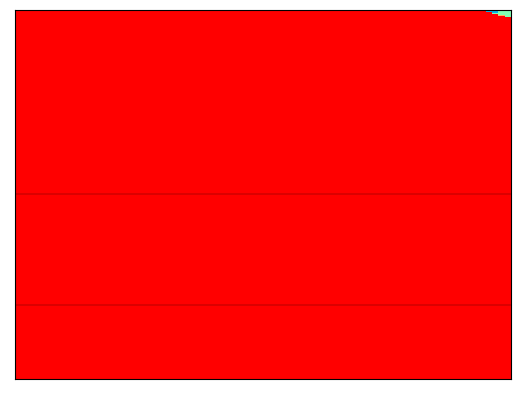

In [32]:
bottom = 0
for i in range(len(categories)):
    plt.bar(results_keys, results_values[:, i], 1, bottom=bottom, label=categories[i], color=colors[i])
    bottom += results_values[:, i]
plt.tick_params(labelbottom=False, labelleft=False)
plt.axhline(1/len(categories), c='k', lw=0.2)
plt.axhline(0.5, c='k', lw=0.2)
plt.margins(0, 0)
plt.xticks([])
plt.yticks([])
# plt.legend()
plt.show()

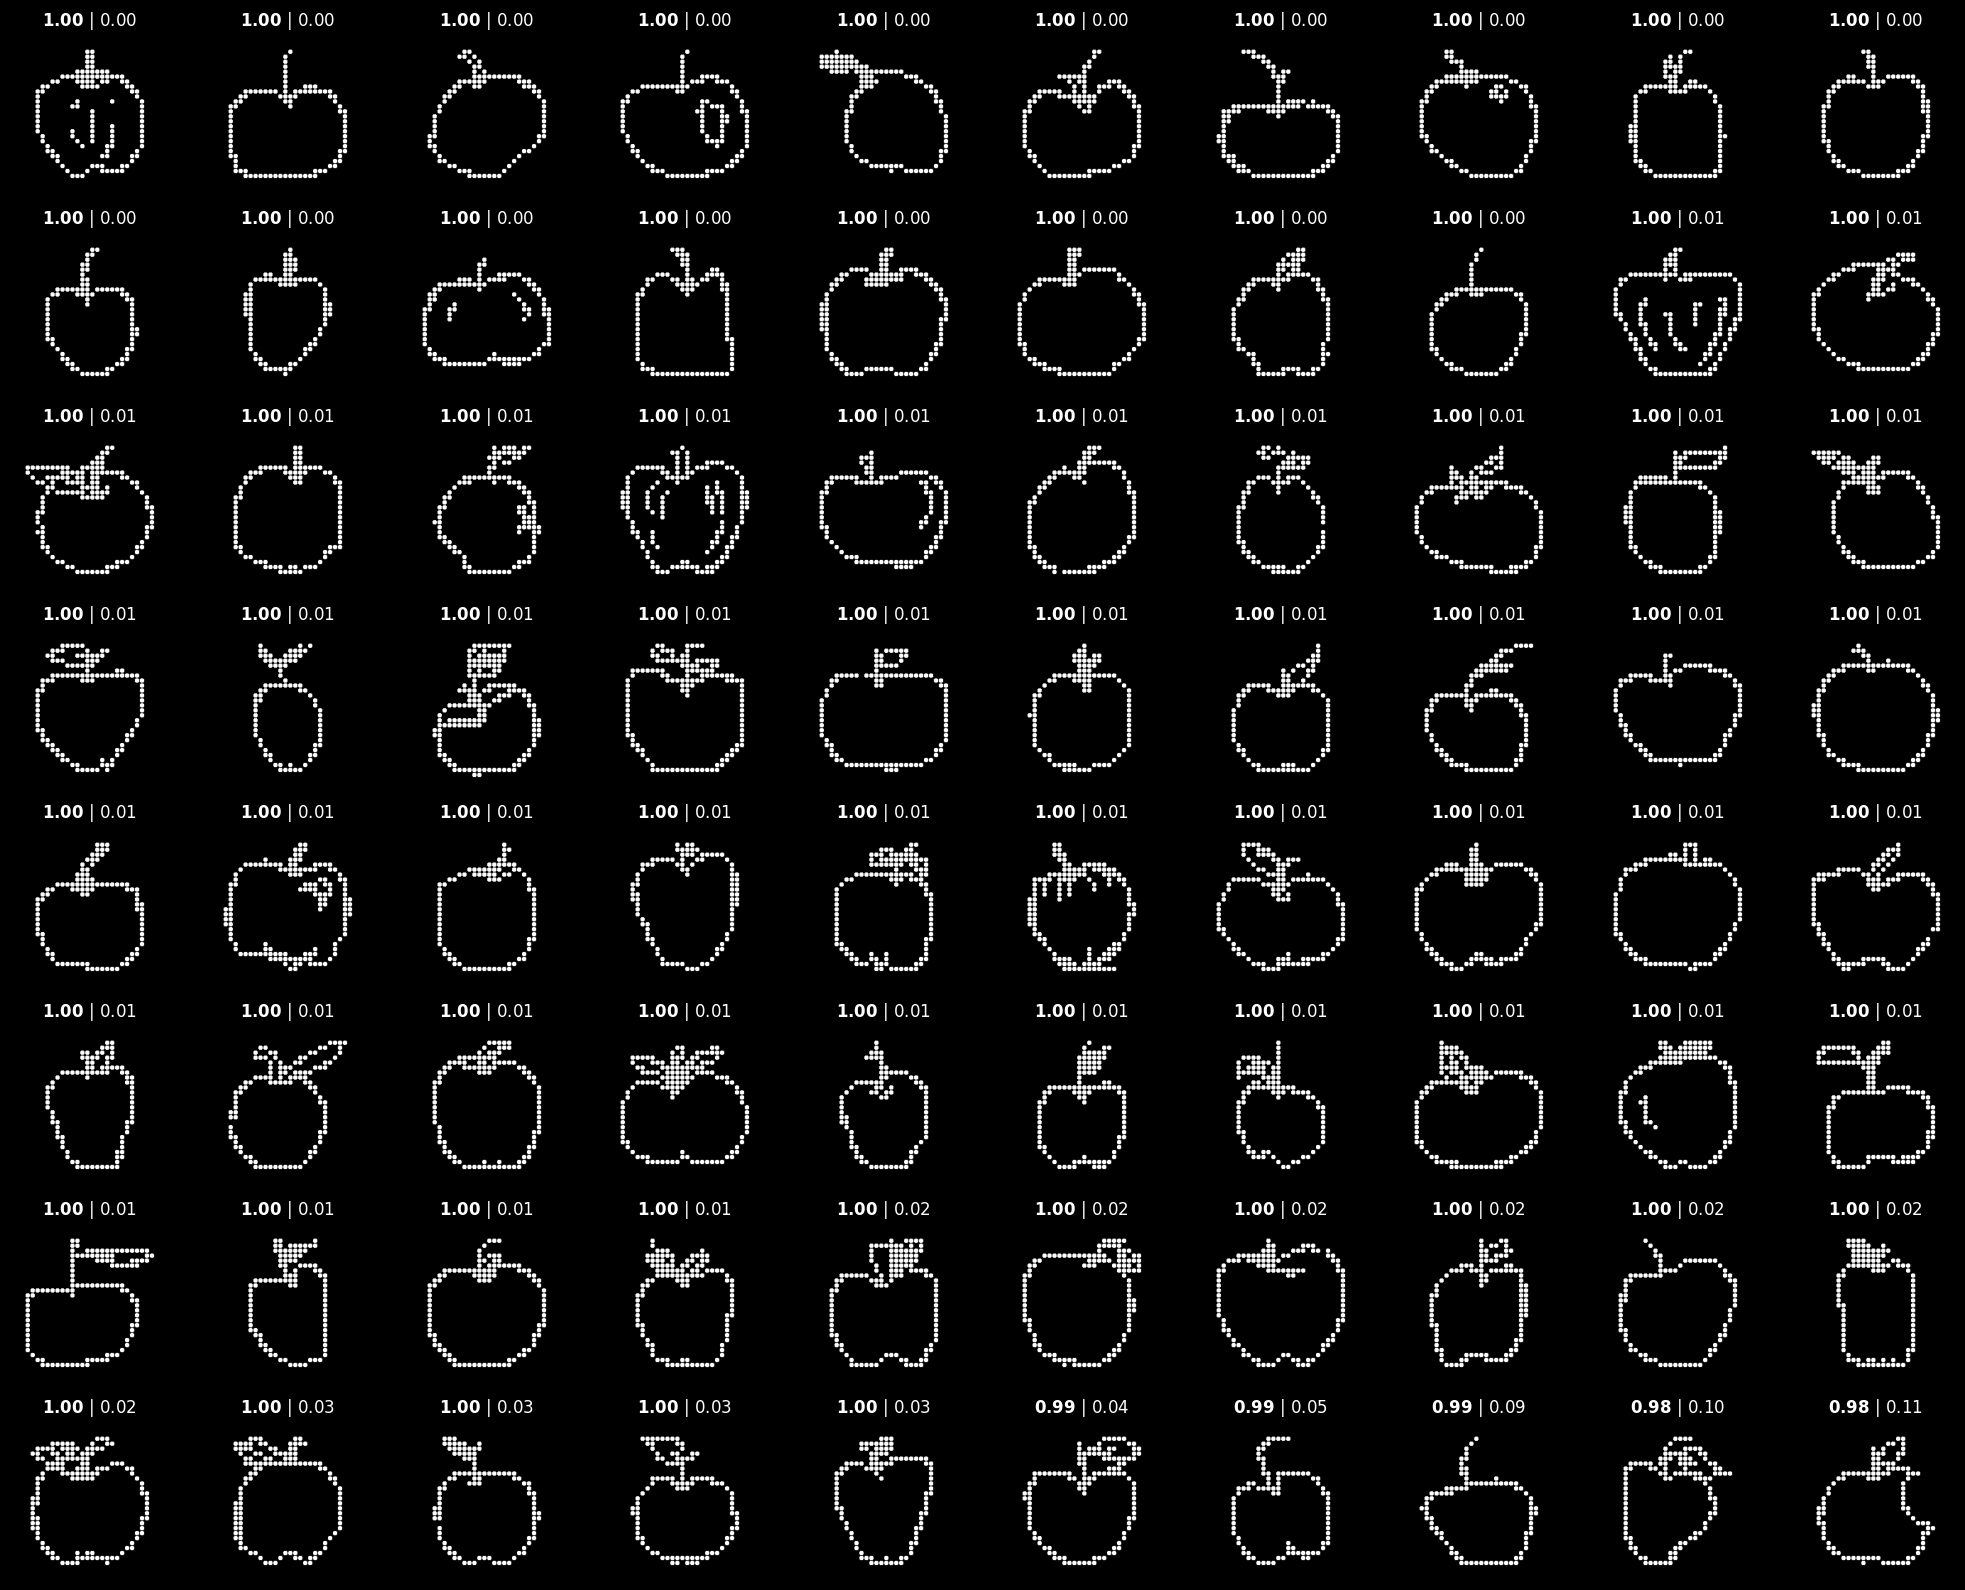

In [33]:
Im.show_images(right_images, CATEGORY, preprocessed_path, results=results)

In [34]:
Im.show_images(wrong_images[::-1], CATEGORY, preprocessed_path, results=results)